In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
#from scipy.optimize import curve_fit
import random


#import scvi
import pickle
from adjustText import adjust_text

import itertools


import senepy as sp #v0.1.1


In [2]:
sc.set_figure_params(dpi_save=600, transparent=True)

In [5]:
#import markers and convert to human format


with open('../data/gene_lists/human_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role

markers = {k.upper(): v for k, v in markers.items()}



#add senmayo

senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist()
#senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo


In [6]:
hubs = sp.load_hubs(species = 'Human')

In [7]:
adata = sc.read_h5ad('/home/jrlab/Downloads/human_adata_ANNOTATED.h5ad')

In [8]:
trans_adata = sp.translator(data = adata, hub = hubs.hubs)

527 of 35495 genes not initially present
2 of 527 translated
525 still not present


In [9]:
temp = adata.obs.groupby(['study', 'tissue', 'cell_type_2']).count()
temp=temp[temp.age > 0]['age']

/tmp/ipykernel_1884252/4213838281.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = adata.obs.groupby(['study', 'tissue', 'cell_type_2']).count()


In [10]:
to_test = temp.reset_index().sort_values('age', ascending = False)

In [11]:
#to_test = to_test[to_test.age > 20]
#to_test = to_test[~to_test.cell_type_2.isin(['NotAssigned', 'm', 'unknown', 'doublets'])].reset_index(drop = True)
to_test

,study,tissue,cell_type_2,age
512,heart,heart,cardiomyocyte,148772
514,heart,heart,endothelial cell,100579
520,heart,heart,pericyte,77856
515,heart,heart,fibroblast,59341
522,heart,heart,unknown,33998
...,...,...,...,...
65,TS,eye,ganglion cell,5
5,TS,adipose,mast cell,4
55,TS,bone marrow,plasmablast,4
34,TS,blood,myeloid progenitor,3


In [69]:
#going to pick one hub per cell/tissue. If cell/tissue hub not present, pick cell-type with highest hyp
#if no cell type, pick highest other hyp
def pick_hub(tissue, cell):
    temp = hubs.metadata[(hubs.metadata.tissue == tissue) & (hubs.metadata.cell == cell)].sort_values('hyp')
    if len(temp) > 0:
        return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num)
    
    temp = hubs.metadata[(hubs.metadata.cell == cell)].sort_values('hyp')
    if len(temp) > 0:
        return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num)
    
    temp = hubs.metadata.sort_values('hyp')
    return (temp.iloc[0].tissue, temp.iloc[0].cell, temp.iloc[0].hub_num) 
        

In [67]:
pick_hub('heart', 'cardiomyocyte')

('heart', 'cardiomyocyte', 1)

In [ ]:
scores = {}
what_hubs = {}

for row in tqdm(range(len(to_test))):
    sub = adata[(adata.obs.study == to_test.loc[row].study) &\
                (adata.obs.tissue == to_test.loc[row].tissue) &\
                (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2)]
    
    sel_hub = pick_hub(to_test.loc[row].tissue, to_test.loc[row].cell_type_2)
    
    res = sp.score_hub(sub, hubs.hubs[sel_hub], translator= trans_adata)
    
    scores = scores | dict(zip(sub.obs.index, res))
    what_hubs[(to_test.loc[row].study, to_test.loc[row].tissue, to_test.loc[row].cell_type_2)] = sel_hub
    

  0%|                                                   | 0/535 [00:00<?, ?it/s]

36/36(100.0%) genes present in data after translation
Still not present: []


  0%|                                         | 1/535 [00:35<5:11:45, 35.03s/it]

41/41(100.0%) genes present in data after translation
Still not present: []


  0%|▏                                        | 2/535 [00:57<4:06:50, 27.79s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  1%|▏                                        | 3/535 [01:14<3:23:40, 22.97s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  1%|▎                                        | 4/535 [01:28<2:49:26, 19.15s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  1%|▍                                        | 5/535 [01:36<2:15:23, 15.33s/it]

208/208(100.0%) genes present in data after translation
Still not present: []


  1%|▍                                        | 6/535 [01:44<1:53:12, 12.84s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  1%|▌                                        | 7/535 [01:50<1:32:53, 10.56s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


  1%|▌                                        | 8/535 [01:56<1:19:55,  9.10s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


  2%|▋                                        | 9/535 [02:02<1:10:20,  8.02s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  2%|▊                                         | 10/535 [02:06<58:31,  6.69s/it]

223/223(100.0%) genes present in data after translation
Still not present: []


  2%|▊                                         | 11/535 [02:10<52:27,  6.01s/it]

57/57(100.0%) genes present in data after translation
Still not present: []


  2%|▉                                         | 12/535 [02:14<46:21,  5.32s/it]

21/21(100.0%) genes present in data after translation
Still not present: []


  2%|█                                         | 13/535 [02:18<43:36,  5.01s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  3%|█                                         | 14/535 [02:22<41:46,  4.81s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  3%|█▏                                        | 15/535 [02:27<40:29,  4.67s/it]

237/237(100.0%) genes present in data after translation
Still not present: []


  3%|█▎                                        | 16/535 [02:31<38:31,  4.45s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


  3%|█▎                                        | 17/535 [02:34<34:25,  3.99s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  3%|█▍                                        | 18/535 [02:37<34:09,  3.96s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  4%|█▍                                        | 19/535 [02:40<30:25,  3.54s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  4%|█▌                                        | 20/535 [02:43<29:06,  3.39s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  4%|█▋                                        | 21/535 [02:46<27:59,  3.27s/it]

208/208(100.0%) genes present in data after translation
Still not present: []


  4%|█▋                                        | 22/535 [02:49<27:53,  3.26s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


  4%|█▊                                        | 23/535 [02:52<25:48,  3.02s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  4%|█▉                                        | 24/535 [02:54<24:24,  2.87s/it]

168/168(100.0%) genes present in data after translation
Still not present: []


  5%|█▉                                        | 25/535 [02:57<22:53,  2.69s/it]

1713/1713(100.0%) genes present in data after translation
Still not present: []


  5%|██                                        | 26/535 [03:02<28:42,  3.38s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


  5%|██                                        | 27/535 [03:04<26:12,  3.09s/it]

4370/4370(100.0%) genes present in data after translation
Still not present: []


  5%|██▏                                       | 28/535 [03:13<41:04,  4.86s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


  5%|██▎                                       | 29/535 [03:16<35:22,  4.19s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  6%|██▎                                       | 30/535 [03:18<29:46,  3.54s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


  6%|██▍                                       | 31/535 [03:20<26:24,  3.14s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  6%|██▌                                       | 32/535 [03:21<22:29,  2.68s/it]

36/36(100.0%) genes present in data after translation
Still not present: []


  6%|██▌                                       | 33/535 [03:24<21:22,  2.56s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


  6%|██▋                                       | 34/535 [03:26<20:06,  2.41s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


  7%|██▋                                       | 35/535 [03:28<18:42,  2.24s/it]

237/237(100.0%) genes present in data after translation
Still not present: []


  7%|██▊                                       | 36/535 [03:29<17:26,  2.10s/it]

1103/1103(100.0%) genes present in data after translation
Still not present: []


  7%|██▉                                       | 37/535 [03:33<20:41,  2.49s/it]

21/21(100.0%) genes present in data after translation
Still not present: []


  7%|██▉                                       | 38/535 [03:34<17:56,  2.17s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


  7%|███                                       | 39/535 [03:36<16:13,  1.96s/it]

857/857(100.0%) genes present in data after translation
Still not present: []


  7%|███▏                                      | 40/535 [03:39<18:58,  2.30s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


  8%|███▏                                      | 41/535 [03:41<17:54,  2.18s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


  8%|███▎                                      | 42/535 [03:42<16:48,  2.05s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  8%|███▍                                      | 43/535 [03:44<16:12,  1.98s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  8%|███▍                                      | 44/535 [03:46<15:10,  1.85s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  8%|███▌                                      | 45/535 [03:48<15:02,  1.84s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


  9%|███▌                                      | 46/535 [03:49<13:28,  1.65s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  9%|███▋                                      | 47/535 [03:51<13:50,  1.70s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  9%|███▊                                      | 48/535 [03:52<13:50,  1.70s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


  9%|███▊                                      | 49/535 [03:54<13:41,  1.69s/it]

208/208(100.0%) genes present in data after translation
Still not present: []


  9%|███▉                                      | 50/535 [03:55<13:03,  1.62s/it]

351/351(100.0%) genes present in data after translation
Still not present: []


 10%|████                                      | 51/535 [03:57<13:20,  1.65s/it]

20/20(100.0%) genes present in data after translation
Still not present: []


 10%|████                                      | 52/535 [03:58<11:57,  1.48s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


 10%|████▏                                     | 53/535 [04:00<11:54,  1.48s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 10%|████▏                                     | 54/535 [04:01<11:32,  1.44s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


 10%|████▎                                     | 55/535 [04:02<10:50,  1.36s/it]

351/351(100.0%) genes present in data after translation
Still not present: []


 10%|████▍                                     | 56/535 [04:04<11:54,  1.49s/it]

168/168(100.0%) genes present in data after translation
Still not present: []


 11%|████▍                                     | 57/535 [04:05<11:29,  1.44s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


 11%|████▌                                     | 58/535 [04:06<10:15,  1.29s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


 11%|████▋                                     | 59/535 [04:07<09:55,  1.25s/it]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 11%|████▋                                     | 60/535 [04:11<15:47,  1.99s/it]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 11%|████▊                                     | 61/535 [04:15<20:31,  2.60s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 12%|████▊                                     | 62/535 [04:16<16:37,  2.11s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 12%|████▉                                     | 63/535 [04:18<15:12,  1.93s/it]

112/112(100.0%) genes present in data after translation
Still not present: []


 12%|█████                                     | 64/535 [04:19<13:08,  1.67s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


 12%|█████                                     | 65/535 [04:20<11:29,  1.47s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 12%|█████▏                                    | 66/535 [04:21<10:36,  1.36s/it]

85/85(100.0%) genes present in data after translation
Still not present: []


 13%|█████▎                                    | 67/535 [04:22<09:51,  1.26s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 13%|█████▎                                    | 68/535 [04:23<09:39,  1.24s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 13%|█████▍                                    | 69/535 [04:24<09:37,  1.24s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 13%|█████▍                                    | 70/535 [04:25<08:47,  1.13s/it]

23/23(100.0%) genes present in data after translation
Still not present: []


 13%|█████▌                                    | 71/535 [04:26<08:30,  1.10s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


 13%|█████▋                                    | 72/535 [04:27<08:27,  1.10s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


 14%|█████▋                                    | 73/535 [04:28<07:45,  1.01s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 14%|█████▊                                    | 74/535 [04:30<08:36,  1.12s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


 14%|█████▉                                    | 75/535 [04:31<08:37,  1.12s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 14%|█████▉                                    | 76/535 [04:32<08:29,  1.11s/it]

38/38(100.0%) genes present in data after translation
Still not present: []


 14%|██████                                    | 77/535 [04:33<07:47,  1.02s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 15%|██████                                    | 78/535 [04:34<08:23,  1.10s/it]

1103/1103(100.0%) genes present in data after translation
Still not present: []


 15%|██████▏                                   | 79/535 [04:36<11:12,  1.48s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 15%|██████▎                                   | 80/535 [04:37<10:27,  1.38s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 15%|██████▎                                   | 81/535 [04:39<10:06,  1.34s/it]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 15%|██████▍                                   | 82/535 [04:42<15:23,  2.04s/it]

838/838(100.0%) genes present in data after translation
Still not present: []


 16%|██████▌                                   | 83/535 [04:44<15:09,  2.01s/it]

384/384(100.0%) genes present in data after translation
Still not present: []


 16%|██████▌                                   | 84/535 [04:46<13:56,  1.86s/it]

1089/1089(100.0%) genes present in data after translation
Still not present: []


 16%|██████▋                                   | 85/535 [04:48<14:59,  2.00s/it]

57/57(100.0%) genes present in data after translation
Still not present: []


 16%|██████▊                                   | 86/535 [04:49<12:47,  1.71s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 16%|██████▊                                   | 87/535 [04:50<11:07,  1.49s/it]

145/145(100.0%) genes present in data after translation
Still not present: []


 16%|██████▉                                   | 88/535 [04:51<09:51,  1.32s/it]

242/242(100.0%) genes present in data after translation
Still not present: []


 17%|██████▉                                   | 89/535 [04:52<09:23,  1.26s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 17%|███████                                   | 90/535 [04:53<09:16,  1.25s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


 17%|███████▏                                  | 91/535 [04:54<08:37,  1.17s/it]

168/168(100.0%) genes present in data after translation
Still not present: []


 17%|███████▏                                  | 92/535 [04:55<08:16,  1.12s/it]

1103/1103(100.0%) genes present in data after translation
Still not present: []


 17%|███████▎                                  | 93/535 [04:58<10:45,  1.46s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 18%|███████▍                                  | 94/535 [04:59<09:53,  1.35s/it]

351/351(100.0%) genes present in data after translation
Still not present: []


 18%|███████▍                                  | 95/535 [05:00<09:34,  1.31s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 18%|███████▌                                  | 96/535 [05:00<08:06,  1.11s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


 18%|███████▌                                  | 97/535 [05:01<07:10,  1.02it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 18%|███████▋                                  | 98/535 [05:02<07:51,  1.08s/it]

41/41(100.0%) genes present in data after translation
Still not present: []


 19%|███████▊                                  | 99/535 [05:03<07:11,  1.01it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 19%|███████▋                                 | 100/535 [05:04<06:48,  1.06it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 19%|███████▋                                 | 101/535 [05:05<06:29,  1.12it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 19%|███████▊                                 | 102/535 [05:06<06:29,  1.11it/s]

1053/1053(100.0%) genes present in data after translation
Still not present: []


 19%|███████▉                                 | 103/535 [05:08<08:59,  1.25s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 19%|███████▉                                 | 104/535 [05:09<08:22,  1.17s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 20%|████████                                 | 105/535 [05:10<07:41,  1.07s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


 20%|████████                                 | 106/535 [05:10<07:01,  1.02it/s]

49/49(100.0%) genes present in data after translation
Still not present: []


 20%|████████▏                                | 107/535 [05:11<06:08,  1.16it/s]

905/905(100.0%) genes present in data after translation
Still not present: []


 20%|████████▎                                | 108/535 [05:13<07:57,  1.12s/it]

112/112(100.0%) genes present in data after translation
Still not present: []


 20%|████████▎                                | 109/535 [05:13<07:06,  1.00s/it]

145/145(100.0%) genes present in data after translation
Still not present: []


 21%|████████▍                                | 110/535 [05:14<06:38,  1.07it/s]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 21%|████████▌                                | 111/535 [05:17<11:27,  1.62s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


 21%|████████▌                                | 112/535 [05:18<09:38,  1.37s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 21%|████████▋                                | 113/535 [05:19<08:12,  1.17s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


 21%|████████▋                                | 114/535 [05:20<07:07,  1.02s/it]

311/311(100.0%) genes present in data after translation
Still not present: []


 21%|████████▊                                | 115/535 [05:21<07:14,  1.03s/it]

57/57(100.0%) genes present in data after translation
Still not present: []


 22%|████████▉                                | 116/535 [05:21<06:27,  1.08it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 22%|████████▉                                | 117/535 [05:22<06:02,  1.15it/s]

1834/1834(100.0%) genes present in data after translation
Still not present: []


 22%|█████████                                | 118/535 [05:25<10:00,  1.44s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


 22%|█████████                                | 119/535 [05:26<08:32,  1.23s/it]

1337/1337(100.0%) genes present in data after translation
Still not present: []


 22%|█████████▏                               | 120/535 [05:28<10:40,  1.54s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


 23%|█████████▎                               | 121/535 [05:29<08:44,  1.27s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 23%|█████████▎                               | 122/535 [05:29<07:46,  1.13s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 23%|█████████▍                               | 123/535 [05:30<06:46,  1.01it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 23%|█████████▌                               | 124/535 [05:31<06:29,  1.05it/s]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 23%|█████████▌                               | 125/535 [05:34<10:51,  1.59s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 24%|█████████▋                               | 126/535 [05:35<09:07,  1.34s/it]

25/25(100.0%) genes present in data after translation
Still not present: []


 24%|█████████▋                               | 127/535 [05:35<07:24,  1.09s/it]

351/351(100.0%) genes present in data after translation
Still not present: []


 24%|█████████▊                               | 128/535 [05:36<07:08,  1.05s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 24%|█████████▉                               | 129/535 [05:37<06:26,  1.05it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 24%|█████████▉                               | 130/535 [05:37<05:25,  1.25it/s]

1747/1747(100.0%) genes present in data after translation
Still not present: []


 24%|██████████                               | 131/535 [05:40<09:08,  1.36s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 25%|██████████                               | 132/535 [05:41<08:01,  1.19s/it]

1103/1103(100.0%) genes present in data after translation
Still not present: []


 25%|██████████▏                              | 133/535 [05:43<09:20,  1.40s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 25%|██████████▎                              | 134/535 [05:43<07:45,  1.16s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 25%|██████████▎                              | 135/535 [05:44<06:52,  1.03s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


 25%|██████████▍                              | 136/535 [05:45<05:49,  1.14it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 26%|██████████▍                              | 137/535 [05:45<04:52,  1.36it/s]

50/50(100.0%) genes present in data after translation
Still not present: []


 26%|██████████▌                              | 138/535 [05:45<04:26,  1.49it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 26%|██████████▋                              | 139/535 [05:46<04:24,  1.50it/s]

1837/1837(100.0%) genes present in data after translation
Still not present: []


 26%|██████████▋                              | 140/535 [05:49<08:28,  1.29s/it]

7/7(100.0%) genes present in data after translation
Still not present: []


 26%|██████████▊                              | 141/535 [05:49<07:00,  1.07s/it]

50/50(100.0%) genes present in data after translation
Still not present: []


 27%|██████████▉                              | 142/535 [05:50<06:01,  1.09it/s]

145/145(100.0%) genes present in data after translation
Still not present: []


 27%|██████████▉                              | 143/535 [05:51<05:21,  1.22it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 27%|███████████                              | 144/535 [05:51<05:03,  1.29it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 27%|███████████                              | 145/535 [05:52<04:45,  1.37it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 27%|███████████▏                             | 146/535 [05:53<04:36,  1.41it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 27%|███████████▎                             | 147/535 [05:53<05:06,  1.27it/s]

49/49(100.0%) genes present in data after translation
Still not present: []


 28%|███████████▎                             | 148/535 [05:54<04:22,  1.47it/s]

1337/1337(100.0%) genes present in data after translation
Still not present: []


 28%|███████████▍                             | 149/535 [05:56<06:54,  1.07s/it]

384/384(100.0%) genes present in data after translation
Still not present: []


 28%|███████████▍                             | 150/535 [05:57<06:23,  1.00it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 28%|███████████▌                             | 151/535 [05:57<05:38,  1.13it/s]

168/168(100.0%) genes present in data after translation
Still not present: []


 28%|███████████▋                             | 152/535 [05:58<05:01,  1.27it/s]

351/351(100.0%) genes present in data after translation
Still not present: []


 29%|███████████▋                             | 153/535 [05:59<05:08,  1.24it/s]

3147/3147(100.0%) genes present in data after translation
Still not present: []


 29%|███████████▊                             | 154/535 [06:03<11:25,  1.80s/it]

351/351(100.0%) genes present in data after translation
Still not present: []


 29%|███████████▉                             | 155/535 [06:04<09:34,  1.51s/it]

112/112(100.0%) genes present in data after translation
Still not present: []


 29%|███████████▉                             | 156/535 [06:04<07:43,  1.22s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 29%|████████████                             | 157/535 [06:05<06:33,  1.04s/it]

112/112(100.0%) genes present in data after translation
Still not present: []


 30%|████████████                             | 158/535 [06:05<05:33,  1.13it/s]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 30%|████████████▏                            | 159/535 [06:08<09:05,  1.45s/it]

168/168(100.0%) genes present in data after translation
Still not present: []


 30%|████████████▎                            | 160/535 [06:09<07:21,  1.18s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 30%|████████████▎                            | 161/535 [06:09<06:20,  1.02s/it]

551/551(100.0%) genes present in data after translation
Still not present: []


 30%|████████████▍                            | 162/535 [06:10<06:25,  1.03s/it]

1053/1053(100.0%) genes present in data after translation
Still not present: []


 30%|████████████▍                            | 163/535 [06:12<07:30,  1.21s/it]

49/49(100.0%) genes present in data after translation
Still not present: []


 31%|████████████▌                            | 164/535 [06:12<06:03,  1.02it/s]

50/50(100.0%) genes present in data after translation
Still not present: []


 31%|████████████▋                            | 165/535 [06:13<05:00,  1.23it/s]

351/351(100.0%) genes present in data after translation
Still not present: []


 31%|████████████▋                            | 166/535 [06:14<04:50,  1.27it/s]

112/112(100.0%) genes present in data after translation
Still not present: []


 31%|████████████▊                            | 167/535 [06:14<04:12,  1.46it/s]

50/50(100.0%) genes present in data after translation
Still not present: []


 31%|████████████▊                            | 168/535 [06:14<03:37,  1.69it/s]

49/49(100.0%) genes present in data after translation
Still not present: []


 32%|████████████▉                            | 169/535 [06:15<03:20,  1.82it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 32%|█████████████                            | 170/535 [06:15<03:15,  1.86it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 32%|█████████████                            | 171/535 [06:16<03:19,  1.83it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 32%|█████████████▏                           | 172/535 [06:17<03:46,  1.60it/s]

112/112(100.0%) genes present in data after translation
Still not present: []


 32%|█████████████▎                           | 173/535 [06:17<03:29,  1.73it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 33%|█████████████▎                           | 174/535 [06:18<03:25,  1.75it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 33%|█████████████▍                           | 175/535 [06:18<03:24,  1.76it/s]

112/112(100.0%) genes present in data after translation
Still not present: []


 33%|█████████████▍                           | 176/535 [06:19<03:09,  1.89it/s]

1747/1747(100.0%) genes present in data after translation
Still not present: []


 33%|█████████████▌                           | 177/535 [06:21<06:31,  1.09s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 33%|█████████████▋                           | 178/535 [06:22<05:25,  1.10it/s]

168/168(100.0%) genes present in data after translation
Still not present: []


 33%|█████████████▋                           | 179/535 [06:22<04:37,  1.29it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 34%|█████████████▊                           | 180/535 [06:23<04:07,  1.43it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 34%|█████████████▊                           | 181/535 [06:23<03:44,  1.58it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 34%|█████████████▉                           | 182/535 [06:24<03:35,  1.64it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 34%|██████████████                           | 183/535 [06:24<03:16,  1.79it/s]

49/49(100.0%) genes present in data after translation
Still not present: []


 34%|██████████████                           | 184/535 [06:25<02:53,  2.03it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 35%|██████████████▏                          | 185/535 [06:25<02:47,  2.10it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 35%|██████████████▎                          | 186/535 [06:25<02:42,  2.15it/s]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 35%|██████████████▎                          | 187/535 [06:28<06:36,  1.14s/it]

551/551(100.0%) genes present in data after translation
Still not present: []


 35%|██████████████▍                          | 188/535 [06:29<06:11,  1.07s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 35%|██████████████▍                          | 189/535 [06:30<05:16,  1.09it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 36%|██████████████▌                          | 190/535 [06:30<04:29,  1.28it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 36%|██████████████▋                          | 191/535 [06:30<03:56,  1.46it/s]

49/49(100.0%) genes present in data after translation
Still not present: []


 36%|██████████████▋                          | 192/535 [06:31<03:19,  1.72it/s]

112/112(100.0%) genes present in data after translation
Still not present: []


 36%|██████████████▊                          | 193/535 [06:31<02:59,  1.90it/s]

1103/1103(100.0%) genes present in data after translation
Still not present: []


 36%|██████████████▊                          | 194/535 [06:33<04:43,  1.20it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 36%|██████████████▉                          | 195/535 [06:33<04:07,  1.37it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 37%|███████████████                          | 196/535 [06:34<03:39,  1.55it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 37%|███████████████                          | 197/535 [06:34<02:56,  1.91it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 37%|███████████████▏                         | 198/535 [06:35<03:15,  1.72it/s]

49/49(100.0%) genes present in data after translation
Still not present: []


 37%|███████████████▎                         | 199/535 [06:35<02:44,  2.04it/s]

1747/1747(100.0%) genes present in data after translation
Still not present: []


 37%|███████████████▎                         | 200/535 [06:37<05:45,  1.03s/it]

161/161(100.0%) genes present in data after translation
Still not present: []


 38%|███████████████▍                         | 201/535 [06:38<04:41,  1.18it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 38%|███████████████▍                         | 202/535 [06:38<04:01,  1.38it/s]

168/168(100.0%) genes present in data after translation
Still not present: []


 38%|███████████████▌                         | 203/535 [06:39<03:31,  1.57it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 38%|███████████████▋                         | 204/535 [06:39<03:15,  1.69it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 38%|███████████████▋                         | 205/535 [06:39<03:02,  1.81it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 39%|███████████████▊                         | 206/535 [06:40<02:48,  1.95it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 39%|███████████████▊                         | 207/535 [06:40<02:38,  2.07it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 39%|███████████████▉                         | 208/535 [06:41<02:16,  2.40it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 39%|████████████████                         | 209/535 [06:41<02:16,  2.40it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 39%|████████████████                         | 210/535 [06:41<02:15,  2.40it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 39%|████████████████▏                        | 211/535 [06:42<02:23,  2.25it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 40%|████████████████▏                        | 212/535 [06:42<02:21,  2.29it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 40%|████████████████▎                        | 213/535 [06:43<02:19,  2.31it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 40%|████████████████▍                        | 214/535 [06:43<02:21,  2.27it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 40%|████████████████▍                        | 215/535 [06:43<02:01,  2.64it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 40%|████████████████▌                        | 216/535 [06:44<02:14,  2.37it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 41%|████████████████▋                        | 217/535 [06:44<02:10,  2.43it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 41%|████████████████▋                        | 218/535 [06:45<02:12,  2.38it/s]

351/351(100.0%) genes present in data after translation
Still not present: []


 41%|████████████████▊                        | 219/535 [06:45<02:31,  2.08it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 41%|████████████████▊                        | 220/535 [06:46<02:23,  2.19it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 41%|████████████████▉                        | 221/535 [06:46<02:18,  2.27it/s]

311/311(100.0%) genes present in data after translation
Still not present: []


 41%|█████████████████                        | 222/535 [06:47<02:34,  2.03it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 42%|█████████████████                        | 223/535 [06:47<02:23,  2.17it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 42%|█████████████████▏                       | 224/535 [06:47<02:03,  2.51it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 42%|█████████████████▏                       | 225/535 [06:48<02:05,  2.48it/s]

1834/1834(100.0%) genes present in data after translation
Still not present: []


 42%|█████████████████▎                       | 226/535 [06:50<05:03,  1.02it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 42%|█████████████████▍                       | 227/535 [06:50<03:54,  1.32it/s]

351/351(100.0%) genes present in data after translation
Still not present: []


 43%|█████████████████▍                       | 228/535 [06:51<03:42,  1.38it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 43%|█████████████████▌                       | 229/535 [06:51<03:09,  1.61it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 43%|█████████████████▋                       | 230/535 [06:52<02:58,  1.71it/s]

7/7(100.0%) genes present in data after translation
Still not present: []


 43%|█████████████████▋                       | 231/535 [06:52<02:25,  2.10it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 43%|█████████████████▊                       | 232/535 [06:53<02:18,  2.19it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 44%|█████████████████▊                       | 233/535 [06:53<02:11,  2.29it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 44%|█████████████████▉                       | 234/535 [06:53<02:06,  2.38it/s]

50/50(100.0%) genes present in data after translation
Still not present: []


 44%|██████████████████                       | 235/535 [06:54<01:49,  2.74it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 44%|██████████████████                       | 236/535 [06:54<01:50,  2.70it/s]

351/351(100.0%) genes present in data after translation
Still not present: []


 44%|██████████████████▏                      | 237/535 [06:55<02:10,  2.28it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 44%|██████████████████▏                      | 238/535 [06:55<02:08,  2.31it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 45%|██████████████████▎                      | 239/535 [06:55<02:04,  2.37it/s]

49/49(100.0%) genes present in data after translation
Still not present: []


 45%|██████████████████▍                      | 240/535 [06:56<01:49,  2.70it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 45%|██████████████████▍                      | 241/535 [06:56<01:49,  2.68it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 45%|██████████████████▌                      | 242/535 [06:56<01:51,  2.62it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 46%|██████████████████▋                      | 244/535 [06:57<01:40,  2.89it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
2047/2047(100.0%) genes present in data after translation
Still not present: []


 46%|██████████████████▊                      | 245/535 [07:00<04:48,  1.01it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 46%|██████████████████▊                      | 246/535 [07:00<03:55,  1.23it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 46%|██████████████████▉                      | 247/535 [07:00<03:15,  1.47it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 46%|███████████████████                      | 248/535 [07:01<03:14,  1.48it/s]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 47%|███████████████████                      | 249/535 [07:04<05:51,  1.23s/it]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 47%|███████████████████▏                     | 250/535 [07:06<07:42,  1.62s/it]

147/147(100.0%) genes present in data after translation
Still not present: []


 47%|███████████████████▎                     | 252/535 [07:07<04:24,  1.07it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 47%|███████████████████▍                     | 253/535 [07:07<03:37,  1.30it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 47%|███████████████████▍                     | 254/535 [07:08<03:05,  1.51it/s]

36/36(100.0%) genes present in data after translation
Still not present: []


 48%|███████████████████▌                     | 255/535 [07:08<02:28,  1.89it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 48%|███████████████████▌                     | 256/535 [07:08<02:16,  2.05it/s]

50/50(100.0%) genes present in data after translation
Still not present: []


 48%|███████████████████▋                     | 257/535 [07:08<01:54,  2.43it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 48%|███████████████████▊                     | 258/535 [07:09<01:52,  2.46it/s]

168/168(100.0%) genes present in data after translation
Still not present: []


 48%|███████████████████▊                     | 259/535 [07:09<01:50,  2.50it/s]

351/351(100.0%) genes present in data after translation
Still not present: []


 49%|███████████████████▉                     | 260/535 [07:10<02:06,  2.17it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 49%|████████████████████                     | 262/535 [07:10<01:40,  2.72it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
351/351(100.0%) genes present in data after translation
Still not present: []


 49%|████████████████████▏                    | 263/535 [07:11<01:58,  2.29it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 50%|████████████████████▎                    | 265/535 [07:11<01:35,  2.84it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
2047/2047(100.0%) genes present in data after translation
Still not present: []


 50%|████████████████████▍                    | 266/535 [07:14<04:28,  1.00it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 50%|████████████████████▍                    | 267/535 [07:14<03:34,  1.25it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 50%|████████████████████▌                    | 268/535 [07:15<02:57,  1.50it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 50%|████████████████████▌                    | 269/535 [07:15<02:33,  1.73it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 50%|████████████████████▋                    | 270/535 [07:15<02:15,  1.96it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 51%|████████████████████▊                    | 271/535 [07:16<02:02,  2.15it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 51%|████████████████████▊                    | 272/535 [07:16<01:55,  2.27it/s]

57/57(100.0%) genes present in data after translation
Still not present: []


 51%|████████████████████▉                    | 274/535 [07:17<01:22,  3.16it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 51%|█████████████████████                    | 275/535 [07:17<01:24,  3.06it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 52%|█████████████████████▏                   | 276/535 [07:17<01:26,  3.00it/s]

168/168(100.0%) genes present in data after translation
Still not present: []


 52%|█████████████████████▏                   | 277/535 [07:18<01:25,  3.02it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 52%|█████████████████████▎                   | 278/535 [07:18<01:24,  3.04it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 52%|█████████████████████▍                   | 279/535 [07:18<01:24,  3.02it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 53%|█████████████████████▌                   | 281/535 [07:19<01:08,  3.68it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 53%|█████████████████████▌                   | 282/535 [07:19<01:15,  3.36it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 53%|█████████████████████▋                   | 283/535 [07:19<01:16,  3.28it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 53%|█████████████████████▊                   | 284/535 [07:20<01:38,  2.55it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 53%|█████████████████████▊                   | 285/535 [07:20<01:34,  2.65it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 53%|█████████████████████▉                   | 286/535 [07:21<01:30,  2.75it/s]

1834/1834(100.0%) genes present in data after translation
Still not present: []


 54%|█████████████████████▉                   | 287/535 [07:23<03:48,  1.09it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 54%|██████████████████████▏                  | 289/535 [07:23<02:21,  1.74it/s]

50/50(100.0%) genes present in data after translation
Still not present: []
384/384(100.0%) genes present in data after translation
Still not present: []


 54%|██████████████████████▎                  | 291/535 [07:24<01:45,  2.31it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
38/38(100.0%) genes present in data after translation
Still not present: []


 55%|██████████████████████▍                  | 293/535 [07:24<01:07,  3.57it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 55%|██████████████████████▌                  | 294/535 [07:25<01:09,  3.47it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 55%|██████████████████████▌                  | 295/535 [07:25<01:18,  3.05it/s]

311/311(100.0%) genes present in data after translation
Still not present: []


 56%|██████████████████████▊                  | 297/535 [07:26<01:12,  3.30it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
1103/1103(100.0%) genes present in data after translation
Still not present: []


 56%|██████████████████████▊                  | 298/535 [07:27<02:28,  1.59it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 56%|██████████████████████▉                  | 299/535 [07:27<02:04,  1.89it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 56%|██████████████████████▉                  | 300/535 [07:28<02:08,  1.83it/s]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 56%|███████████████████████                  | 301/535 [07:30<04:19,  1.11s/it]

384/384(100.0%) genes present in data after translation
Still not present: []


 57%|███████████████████████▏                 | 303/535 [07:31<02:45,  1.40it/s]

57/57(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 57%|███████████████████████▎                 | 304/535 [07:31<02:16,  1.69it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 57%|███████████████████████▍                 | 306/535 [07:32<01:34,  2.43it/s]

57/57(100.0%) genes present in data after translation
Still not present: []
50/50(100.0%) genes present in data after translation
Still not present: []


 57%|███████████████████████▌                 | 307/535 [07:32<01:16,  2.98it/s]

147/147(100.0%) genes present in data after translation
Still not present: []


 58%|███████████████████████▌                 | 308/535 [07:32<01:12,  3.15it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 58%|███████████████████████▊                 | 310/535 [07:33<01:00,  3.69it/s]

50/50(100.0%) genes present in data after translation
Still not present: []
49/49(100.0%) genes present in data after translation
Still not present: []


 58%|███████████████████████▉                 | 312/535 [07:33<00:46,  4.82it/s]

7/7(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 59%|███████████████████████▉                 | 313/535 [07:33<00:52,  4.25it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 59%|████████████████████████                 | 314/535 [07:34<01:01,  3.58it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 59%|████████████████████████▏                | 315/535 [07:34<01:02,  3.52it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 59%|████████████████████████▎                | 317/535 [07:35<00:53,  4.04it/s]

49/49(100.0%) genes present in data after translation
Still not present: []
49/49(100.0%) genes present in data after translation
Still not present: []


 60%|████████████████████████▍                | 319/535 [07:35<00:44,  4.86it/s]

49/49(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 60%|████████████████████████▌                | 320/535 [07:35<00:50,  4.26it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 60%|████████████████████████▌                | 321/535 [07:35<00:54,  3.96it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 60%|████████████████████████▋                | 322/535 [07:36<01:02,  3.42it/s]

242/242(100.0%) genes present in data after translation
Still not present: []


 60%|████████████████████████▊                | 323/535 [07:36<01:08,  3.10it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 61%|████████████████████████▊                | 324/535 [07:37<01:05,  3.22it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 61%|████████████████████████▉                | 325/535 [07:37<01:05,  3.23it/s]

384/384(100.0%) genes present in data after translation
Still not present: []


 61%|████████████████████████▉                | 326/535 [07:37<01:18,  2.66it/s]

168/168(100.0%) genes present in data after translation
Still not present: []


 61%|█████████████████████████                | 327/535 [07:38<01:12,  2.87it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 61%|█████████████████████████▏               | 329/535 [07:38<00:56,  3.62it/s]

49/49(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 62%|█████████████████████████▎               | 331/535 [07:39<00:49,  4.11it/s]

50/50(100.0%) genes present in data after translation
Still not present: []
49/49(100.0%) genes present in data after translation
Still not present: []


 62%|█████████████████████████▌               | 333/535 [07:39<00:41,  4.92it/s]

57/57(100.0%) genes present in data after translation
Still not present: []
7/7(100.0%) genes present in data after translation
Still not present: []


 62%|█████████████████████████▌               | 334/535 [07:39<00:34,  5.79it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 63%|█████████████████████████▋               | 335/535 [07:39<00:41,  4.82it/s]

2047/2047(100.0%) genes present in data after translation
Still not present: []


 63%|█████████████████████████▋               | 336/535 [07:42<02:52,  1.15it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 63%|█████████████████████████▉               | 338/535 [07:42<01:46,  1.85it/s]

49/49(100.0%) genes present in data after translation
Still not present: []
161/161(100.0%) genes present in data after translation
Still not present: []


 63%|█████████████████████████▉               | 339/535 [07:42<01:30,  2.16it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 64%|██████████████████████████               | 340/535 [07:43<01:20,  2.43it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 64%|██████████████████████████▏              | 341/535 [07:43<01:12,  2.67it/s]

119/133(89.47%) genes present in data
119/133(89.47%) genes present in data after translation
Still not present: ['RETREG1', 'SPART', 'AL354809.1', 'AL133304.3', 'SILC1', 'C1QTNF3-AMACR', 'HDAC2-AS2', 'C5orf64', 'LINC01630', 'RP11-566D24.2', 'AC108047.1', 'AC090015.1', 'AC078881.1', 'AL596218.1']


 64%|██████████████████████████▏              | 342/535 [07:43<01:04,  2.99it/s]

161/161(100.0%) genes present in data after translation
Still not present: []


 64%|██████████████████████████▎              | 343/535 [07:44<01:01,  3.10it/s]

In [93]:
adata.obs['sen_score'] = adata.obs.index.map(scores)

In [99]:
means = {}
stds = {}
for row in tqdm(range(len(to_test))):
    sub = adata[(adata.obs.study == to_test.loc[row].study) &\
                (adata.obs.tissue == to_test.loc[row].tissue) &\
                (adata.obs.cell_type_2 == to_test.loc[row].cell_type_2)]
    means[(to_test.loc[row].study, to_test.loc[row].tissue, to_test.loc[row].cell_type_2)] = sub.obs.sen_score.mean()
    stds[(to_test.loc[row].study, to_test.loc[row].tissue, to_test.loc[row].cell_type_2)] = sub.obs.sen_score.std()
    

100%|████████████████████████████████████████| 535/535 [00:03<00:00, 135.46it/s]


In [117]:
def find_outliers(x):
    study, tissue, cell, score = x

    try:
        mean = means[(study, tissue, cell)]
        std = stds[(study, tissue, cell)]
    except:
        return False

    if score > mean + std*3:
        return True
    else:
        return False
    

In [118]:
adata.obs['sen_outlier'] = adata.obs[['study', 'tissue', 'cell_type_2', 'sen_score']].apply(find_outliers, axis = 1)

In [122]:
#adata.obs[['sen_score', 'sen_outlier']].to_pickle('../data/files/8_HUMAN_ADATA_HUB_SCORES_FILTERED_v1.pickle')

In [12]:
adata.obs = pd.concat((adata.obs, pd.read_pickle('../data/files/8_HUMAN_ADATA_HUB_SCORES_FILTERED_v1.pickle')), axis = 1)

In [15]:
hippo = sc.read_h5ad('/home/jrlab/Downloads/human_hippo_ANNOTATED.h5ad')
trans_hippo = sp.translator(data = hippo, hub = hubs.hubs)

3648 of 35495 genes not initially present
124 of 3648 translated
3524 still not present


In [16]:
temp = hippo.obs.groupby(['study', 'tissue', 'cell_type_2']).count()
temp = temp[temp.age > 0]['age']
to_test_hippo = temp.reset_index().sort_values('age', ascending = False)
to_test_hippo

/tmp/ipykernel_1884252/3479312368.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = hippo.obs.groupby(['study', 'tissue', 'cell_type_2']).count()


,study,tissue,cell_type_2,age
7,hippo,hippocampus,excitatory neuron,58864
9,hippo,hippocampus,oligodendrocyte,46771
4,hippo,hippocampus,dentate granule cell,43879
1,hippo,hippocampus,astrocyte,20703
0,hippo,hippocampus,GABA interneuron,16603
10,hippo,hippocampus,oligodendrocyte precursor cell,13579
8,hippo,hippocampus,microglia,7329
3,hippo,hippocampus,choroid plexus cells,2319
5,hippo,hippocampus,endothelial cells,2002
6,hippo,hippocampus,ependymal cell,1791


In [216]:
scores = {}
what_hubs = {}

for row in tqdm(range(len(to_test_hippo))):
    sub = hippo[(hippo.obs.study == to_test_hippo.loc[row].study) &\
                (hippo.obs.tissue == to_test_hippo.loc[row].tissue) &\
                (hippo.obs.cell_type_2 == to_test_hippo.loc[row].cell_type_2)]
    
    sel_hub = pick_hub(to_test_hippo.loc[row].tissue, to_test_hippo.loc[row].cell_type_2)
    
    res = sp.score_hub(sub, hubs.hubs[sel_hub], translator= trans_hippo)
    
    scores = scores | dict(zip(sub.obs.index, res))
    what_hubs[(to_test_hippo.loc[row].study, to_test_hippo.loc[row].tissue, to_test_hippo.loc[row].cell_type_2)] = sel_hub
    

  0%|                                                    | 0/11 [00:00<?, ?it/s]

112/161(69.57%) genes present in data
115/161(71.43%) genes present in data after translation
Still not present: ['IGLV2-14', 'MMP12', 'IGKV3-20', 'PMAIP1', 'CLECL1', 'CD79A', 'IGHV3-23', 'ITGB7', 'SHOX2', 'MTFP1', 'CLEC5A', 'GBP5', 'CCL7', 'IGLV1-47', 'IL10', 'IGLC3', 'MZB1', 'JCHAIN', 'IGKV3-11', 'IGHV4-39', 'FOLR2', 'CHST13', 'CD209', 'IGLV3-1', 'APOBEC3A', 'MMP9', 'CCL13', 'CCR5', 'CCL8', 'CYP27B1', 'IGFLR1', 'IGHV1-2', 'IGLV3-19', 'IGKV1-39', 'MMP1', 'CCL5', 'CD48', 'IGLV3-21', 'CCL2', 'GPR84', 'IGHV5-51', 'IGHA1', 'ADAMDEC1', 'SLAMF7', 'CXCL9', 'CD180']


  9%|████                                        | 1/11 [00:04<00:44,  4.45s/it]

112/161(69.57%) genes present in data
115/161(71.43%) genes present in data after translation
Still not present: ['IGLV2-14', 'MMP12', 'IGKV3-20', 'PMAIP1', 'CLECL1', 'CD79A', 'IGHV3-23', 'ITGB7', 'SHOX2', 'MTFP1', 'CLEC5A', 'GBP5', 'CCL7', 'IGLV1-47', 'IL10', 'IGLC3', 'MZB1', 'JCHAIN', 'IGKV3-11', 'IGHV4-39', 'FOLR2', 'CHST13', 'CD209', 'IGLV3-1', 'APOBEC3A', 'MMP9', 'CCL13', 'CCR5', 'CCL8', 'CYP27B1', 'IGFLR1', 'IGHV1-2', 'IGLV3-19', 'IGKV1-39', 'MMP1', 'CCL5', 'CD48', 'IGLV3-21', 'CCL2', 'GPR84', 'IGHV5-51', 'IGHA1', 'ADAMDEC1', 'SLAMF7', 'CXCL9', 'CD180']


 27%|████████████                                | 3/11 [00:10<00:22,  2.80s/it]

112/161(69.57%) genes present in data
115/161(71.43%) genes present in data after translation
Still not present: ['IGLV2-14', 'MMP12', 'IGKV3-20', 'PMAIP1', 'CLECL1', 'CD79A', 'IGHV3-23', 'ITGB7', 'SHOX2', 'MTFP1', 'CLEC5A', 'GBP5', 'CCL7', 'IGLV1-47', 'IL10', 'IGLC3', 'MZB1', 'JCHAIN', 'IGKV3-11', 'IGHV4-39', 'FOLR2', 'CHST13', 'CD209', 'IGLV3-1', 'APOBEC3A', 'MMP9', 'CCL13', 'CCR5', 'CCL8', 'CYP27B1', 'IGFLR1', 'IGHV1-2', 'IGLV3-19', 'IGKV1-39', 'MMP1', 'CCL5', 'CD48', 'IGLV3-21', 'CCL2', 'GPR84', 'IGHV5-51', 'IGHA1', 'ADAMDEC1', 'SLAMF7', 'CXCL9', 'CD180']
1495/1495(100.0%) genes present in data after translation
Still not present: []


 36%|████████████████                            | 4/11 [00:12<00:19,  2.74s/it]

112/161(69.57%) genes present in data
115/161(71.43%) genes present in data after translation
Still not present: ['IGLV2-14', 'MMP12', 'IGKV3-20', 'PMAIP1', 'CLECL1', 'CD79A', 'IGHV3-23', 'ITGB7', 'SHOX2', 'MTFP1', 'CLEC5A', 'GBP5', 'CCL7', 'IGLV1-47', 'IL10', 'IGLC3', 'MZB1', 'JCHAIN', 'IGKV3-11', 'IGHV4-39', 'FOLR2', 'CHST13', 'CD209', 'IGLV3-1', 'APOBEC3A', 'MMP9', 'CCL13', 'CCR5', 'CCL8', 'CYP27B1', 'IGFLR1', 'IGHV1-2', 'IGLV3-19', 'IGKV1-39', 'MMP1', 'CCL5', 'CD48', 'IGLV3-21', 'CCL2', 'GPR84', 'IGHV5-51', 'IGHA1', 'ADAMDEC1', 'SLAMF7', 'CXCL9', 'CD180']


 45%|████████████████████                        | 5/11 [00:24<00:35,  5.86s/it]

165/165(100.0%) genes present in data after translation
Still not present: []


 55%|████████████████████████                    | 6/11 [00:24<00:20,  4.11s/it]

1559/1559(100.0%) genes present in data after translation
Still not present: []


 64%|████████████████████████████                | 7/11 [00:27<00:14,  3.61s/it]

390/390(100.0%) genes present in data after translation
Still not present: []


 73%|████████████████████████████████            | 8/11 [00:43<00:22,  7.61s/it]

133/133(100.0%) genes present in data after translation
Still not present: []


 82%|████████████████████████████████████        | 9/11 [00:45<00:11,  5.79s/it]

112/161(69.57%) genes present in data
115/161(71.43%) genes present in data after translation
Still not present: ['IGLV2-14', 'MMP12', 'IGKV3-20', 'PMAIP1', 'CLECL1', 'CD79A', 'IGHV3-23', 'ITGB7', 'SHOX2', 'MTFP1', 'CLEC5A', 'GBP5', 'CCL7', 'IGLV1-47', 'IL10', 'IGLC3', 'MZB1', 'JCHAIN', 'IGKV3-11', 'IGHV4-39', 'FOLR2', 'CHST13', 'CD209', 'IGLV3-1', 'APOBEC3A', 'MMP9', 'CCL13', 'CCR5', 'CCL8', 'CYP27B1', 'IGFLR1', 'IGHV1-2', 'IGLV3-19', 'IGKV1-39', 'MMP1', 'CCL5', 'CD48', 'IGLV3-21', 'CCL2', 'GPR84', 'IGHV5-51', 'IGHA1', 'ADAMDEC1', 'SLAMF7', 'CXCL9', 'CD180']


 91%|███████████████████████████████████████    | 10/11 [00:56<00:07,  7.55s/it]

112/161(69.57%) genes present in data
115/161(71.43%) genes present in data after translation
Still not present: ['IGLV2-14', 'MMP12', 'IGKV3-20', 'PMAIP1', 'CLECL1', 'CD79A', 'IGHV3-23', 'ITGB7', 'SHOX2', 'MTFP1', 'CLEC5A', 'GBP5', 'CCL7', 'IGLV1-47', 'IL10', 'IGLC3', 'MZB1', 'JCHAIN', 'IGKV3-11', 'IGHV4-39', 'FOLR2', 'CHST13', 'CD209', 'IGLV3-1', 'APOBEC3A', 'MMP9', 'CCL13', 'CCR5', 'CCL8', 'CYP27B1', 'IGFLR1', 'IGHV1-2', 'IGLV3-19', 'IGKV1-39', 'MMP1', 'CCL5', 'CD48', 'IGLV3-21', 'CCL2', 'GPR84', 'IGHV5-51', 'IGHA1', 'ADAMDEC1', 'SLAMF7', 'CXCL9', 'CD180']


100%|███████████████████████████████████████████| 11/11 [01:00<00:00,  5.48s/it]


In [217]:
hippo.obs['sen_score'] = hippo.obs.index.map(scores)

In [218]:
means = {}
stds = {}
for row in tqdm(range(len(to_test_hippo))):
    sub = hippo[(hippo.obs.study == to_test_hippo.loc[row].study) &\
                (hippo.obs.tissue == to_test_hippo.loc[row].tissue) &\
                (hippo.obs.cell_type_2 == to_test_hippo.loc[row].cell_type_2)]
    means[(to_test_hippo.loc[row].study, to_test_hippo.loc[row].tissue, to_test_hippo.loc[row].cell_type_2)] = sub.obs.sen_score.mean()
    stds[(to_test_hippo.loc[row].study, to_test_hippo.loc[row].tissue, to_test_hippo.loc[row].cell_type_2)] = sub.obs.sen_score.std()
    

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 90.91it/s]


In [219]:
hippo.obs['sen_outlier'] = hippo.obs[['study', 'tissue', 'cell_type_2', 'sen_score']].apply(find_outliers, axis = 1)

In [222]:
obs = pd.concat((adata.obs, hippo.obs))

In [232]:
#obs.to_csv('../data/files/8_SCORED_OBS_HIPPO_AND_ADATA.csv')

In [2]:
obs = pd.read_csv('../data/files/8_SCORED_OBS_HIPPO_AND_ADATA.csv')

/tmp/ipykernel_2173650/3921962327.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv('../data/files/8_SCORED_OBS_HIPPO_AND_ADATA.csv')


In [7]:
out = {}

for age in obs.bin_age.sort_values().unique():
    temp = []
    tissues = []
    cells = []
    for tissue, cell in set([(x[0], x[1]) for x in list((hubs.hubs))]):
        sub = obs[(obs.tissue == tissue) &\
                    (obs.cell_type_2 == cell) &\
                    (obs.bin_age == age)]
        
    
        if len(sub) < 1:
            temp.append(-1)
        else:
            #split by study to minimize study differences
            study = sub.groupby('study').count().sort_values('tissue', ascending = False).index[0]
            sub = sub[sub.study == study]
            
            if len(sub) > 200:
                temp.append(len(sub[sub.sen_outlier])/len(sub))
            else:
                temp.append(-1)
            
        tissues.append(tissue)
        cells.append(cell)
            
    
    if age == 8:
        out['tissue'] = tissues
        out['cell'] = cells
    
    out[age] = temp
    
    
    
    


In [8]:
df = pd.DataFrame(out)

In [9]:
df

,tissue,cell,8,18,28,38,48,58,68,78,88
0,heart,lymphoid cell,-1.000000,-1.000000,-1.000000,0.061037,0.033490,0.024661,-1.000000,-1.000000,-1.000000
1,heart,neuronal cell,-1.000000,-1.000000,-1.000000,0.000000,0.001253,0.072893,0.002667,-1.000000,-1.000000
2,lung,fibroblast,-1.000000,0.012136,-1.000000,-1.000000,-1.000000,0.011905,-1.000000,-1.000000,-1.000000
3,blood,naive b cell,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.001393,0.037037,-1.000000,-1.000000
4,skin,spinous cell,-1.000000,0.004973,-1.000000,0.008997,0.027910,-1.000000,-1.000000,-1.000000,-1.000000
5,lung,macrophage,-1.000000,0.000248,0.004091,0.012008,0.011872,0.016941,0.084679,-1.000000,-1.000000
6,hippocampus,endothelial cells,0.014433,-1.000000,-1.000000,0.007092,-1.000000,-1.000000,0.036117,0.003145,0.014440
7,skin,fibroblast,-1.000000,0.000000,-1.000000,0.006452,0.030600,-1.000000,-1.000000,-1.000000,-1.000000
8,blood,memory b cell,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,0.003745,0.067416,-1.000000,-1.000000
9,liver,endothelial cell,-1.000000,0.006803,-1.000000,0.012262,0.025641,0.044944,-1.000000,-1.000000,-1.000000


In [10]:
#df['Max'] = df[[18, 28, 38, 48, 58, 68]].max(axis = 1)
df['Max_time'] = df[[18, 28, 38, 48, 58, 68, 78, 88]].idxmax(axis = 1)
df = df.replace(-1, 69)
df['min_time'] = df[[18, 28, 38, 48, 58, 68, 78, 88]].idxmin(axis = 1)
df = df.replace(69, -1)
df['does_increase'] = df['Max_time'] - df['min_time']
df['Max_per'] = df[[18, 28, 38, 48, 58, 68, 78, 88]].max(axis = 1)*100

In [12]:
df.sort_values("Max_per")

,tissue,cell,8,18,28,38,48,58,68,78,88,Max_time,min_time,does_increase,Max_per
2,lung,fibroblast,-1.000000,0.012136,-1.000000,-1.000000,-1.000000,0.011905,-1.000000,-1.000000,-1.000000,18,58,-40,1.213592
24,bone marrow,t cell,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.018014,-1.000000,-1.000000,-1.000000,58,38,20,1.801363
11,heart,endothelial cell,-1.000000,-1.000000,-1.000000,0.000000,0.001216,0.023772,0.004148,-1.000000,-1.000000,58,38,20,2.377193
38,liver,macrophage,-1.000000,0.021395,-1.000000,0.026369,0.021173,0.010862,-1.000000,-1.000000,-1.000000,38,58,-20,2.636917
4,skin,spinous cell,-1.000000,0.004973,-1.000000,0.008997,0.027910,-1.000000,-1.000000,-1.000000,-1.000000,48,18,30,2.791014
43,tongue,basal cell,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.006562,0.028385,-1.000000,-1.000000,68,58,10,2.838469
7,skin,fibroblast,-1.000000,0.000000,-1.000000,0.006452,0.030600,-1.000000,-1.000000,-1.000000,-1.000000,48,18,30,3.059976
41,skin,endothelial cell,-1.000000,0.008636,0.002401,-1.000000,-1.000000,0.031513,-1.000000,-1.000000,-1.000000,58,28,30,3.151261
12,heart,adipocyte,-1.000000,-1.000000,-1.000000,0.012642,0.011132,0.023377,0.033898,-1.000000,-1.000000,68,48,20,3.389831
6,hippocampus,endothelial cells,0.014433,-1.000000,-1.000000,0.007092,-1.000000,-1.000000,0.036117,0.003145,0.014440,68,78,-10,3.611738


In [13]:
to_graph = df[df.does_increase > 0].sort_values('Max_per')

In [14]:
#to_graph['term2'] = to_graph.Term.map(fix_term)

cell_type_2_annotations = pd.read_csv('../data/annotations/human/cell_classes.csv')

class_d = dict(zip(cell_type_2_annotations.cell_type_2, cell_type_2_annotations['class']))

to_graph['Class'] = to_graph.cell.map(class_d)

In [15]:
color_d = dict(zip(['endothelial', 'epithelial', 'immune', 'parenchymal', 'progenitor', 'stromal'],
                  ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red']))

In [16]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
from matplotlib import cm

### Figure 5D

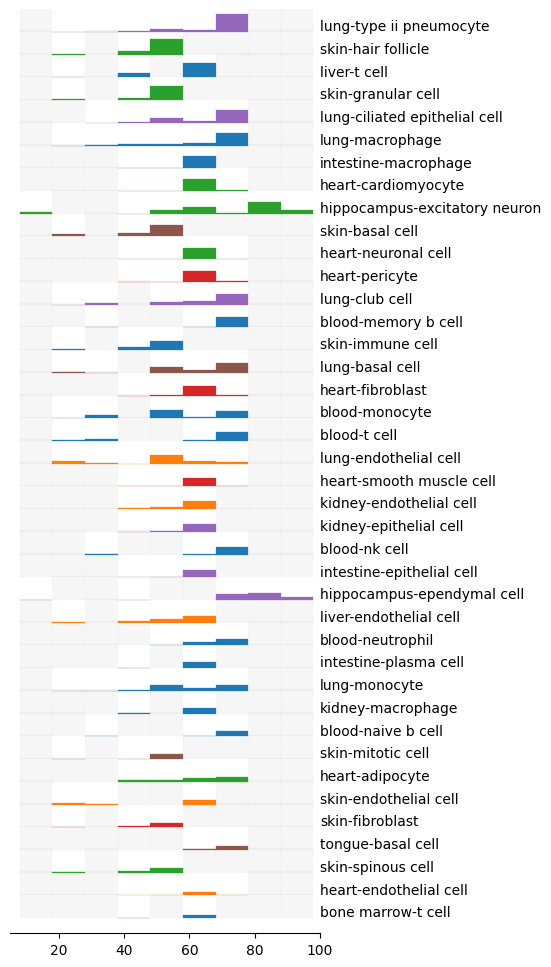

In [17]:



fig, ax = plt.subplots(figsize=(4,12))


#ax.add_patch(Rectangle(xy = (0.2, 0.3), width = 0.5, height = 0.4, linewidth=1, edgecolor='r', facecolor='none'))
for row in range(len(to_graph)):
    plt.text(y = row*15-1, x =100, s = to_graph.iloc[row]['tissue'] + '-' + to_graph.iloc[row]['cell'], va = 'bottom')
    
    for age in [8, 18, 28, 38, 48, 58, 68, 78, 88]:
        
        val = to_graph.iloc[row][age]
        if val != -1:
            c = color_d[to_graph.iloc[row]['Class']]
            ax.add_patch(Rectangle(xy = (age, row*15),
                                   width = 10,
                                   height = val*100,
                                   linewidth=.2,
                                   edgecolor=c,
                                   facecolor=c))
        else:
            ax.add_patch(Rectangle(xy = (age, row*15),
                                   width = 10,
                                   height = 16,
                                   linewidth=.2,
                                   edgecolor='lightgrey',
                                   facecolor='lightgrey', alpha = 0.2))            
            
            
            
            
        
ax.set_xlim(5, 100)
ax.set_ylim(-10, len(to_graph)*15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='both', left=False)

ax.set_yticklabels([])


plt.savefig('figures/5D.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/5D.svg', bbox_inches = 'tight')

plt.show()

In [18]:
heart = obs[obs.study == 'heart']

In [20]:
temp = heart[['donor', 'sen_outlier', 'cell_type_2', 'age']].groupby(['donor','cell_type_2']).agg({
    'sen_outlier': 'sum', # sum of 'sen_outlier'
    'cell_type_2': 'count',
    'age':'first'# count of rows for each 'donor' and 'cell_type'
})

temp = temp.rename(columns = {'cell_type_2':'total'}).reset_index()

In [21]:
temp['per'] = temp.sen_outlier/temp.total

In [22]:
temp = temp.sort_values(['age', 'donor'])

In [24]:
to_show = temp[temp.per > 0.02].cell_type_2.unique()

In [25]:
import matplotlib as mpl
mpl.rcdefaults()

### Fig 5E

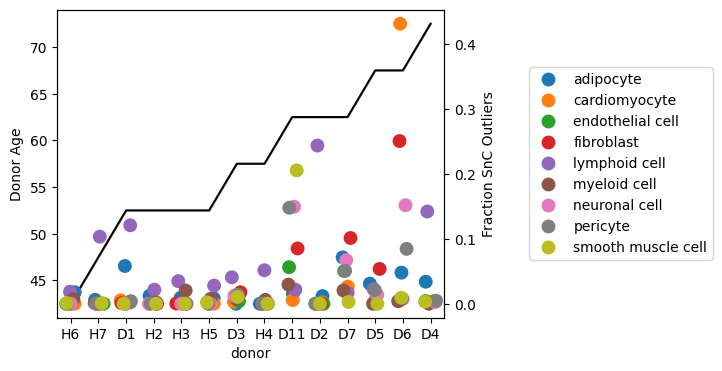

In [48]:
fig, ax1 = plt.subplots(figsize=(5, 4))


sns.lineplot(data=temp[temp.cell_type_2.isin(to_show)],
            x='donor', y='age', color='k', ax=ax1)


# Create a secondary y-axis for the barplot
ax2 = ax1.twinx()  # This creates a second y-axis sharing the same x-axis

sns.stripplot(data=temp[temp.cell_type_2.isin(to_show)],
              x='donor', y='per', hue='cell_type_2',
              palette='tab10', size=10, jitter=.2, ax=ax2)


legend = ax2.legend()
legend.set_title('')

ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))


# Optionally, you can set labels for both y-axes and a title
ax1.set_ylabel('Donor Age')
ax2.set_ylabel('Fraction SnC Outliers')

plt.savefig('figures/5E_v2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/5E_v2.svg', bbox_inches = 'tight')

plt.show()

In [108]:
#plot umap of senpy+ cells

In [2]:
obs = pd.read_csv('../data/files/8_SCORED_OBS_HIPPO_AND_ADATA.csv')

/tmp/ipykernel_1255701/3921962327.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv('../data/files/8_SCORED_OBS_HIPPO_AND_ADATA.csv')


In [3]:
adata = sc.read_h5ad('for_poster/human_all_highly_var_SCVI.h5ad')

In [4]:
np.array_equal(adata.obs.index.values, obs['Unnamed: 0'].values)

True

In [5]:
adata.obs['sen_outlier'] = obs['sen_outlier'].values*1

In [6]:
cell_type_2_annotations = pd.read_csv('../data/annotations/human/cell_classes.csv')

class_d = dict(zip(cell_type_2_annotations.cell_type_2, cell_type_2_annotations['class']))

In [7]:
adata.obs['Class'] = adata.obs.cell_type_2.map(class_d)

In [8]:
def another_fun_y(x):
    age, thing = x
    if age < 50 and thing == 1:
        return 'young pos'
    return 'neg'

def another_fun_o(x):
    age, thing = x
    if age >= 50 and thing == 1:
        return 'old pos'
    return 'neg'

In [9]:
adata.obs['thing_young'] = adata.obs[['age', 'sen_outlier']].apply(another_fun_y, axis = 1)
adata.obs['thing_old'] = adata.obs[['age', 'sen_outlier']].apply(another_fun_o, axis = 1)

In [10]:
adata = adata[~adata.obs.Class.isin(['doublets', 'erythroid-like', 'unknown'])]

adata.obs['Class'] = adata.obs['Class'].replace({'germ line': 'progenitor'})

/tmp/ipykernel_1255701/3780595399.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Class'] = adata.obs['Class'].replace({'germ line': 'progenitor'})


In [60]:
sc.set_figure_params(dpi_save = 600)

### Figure 5B

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for color

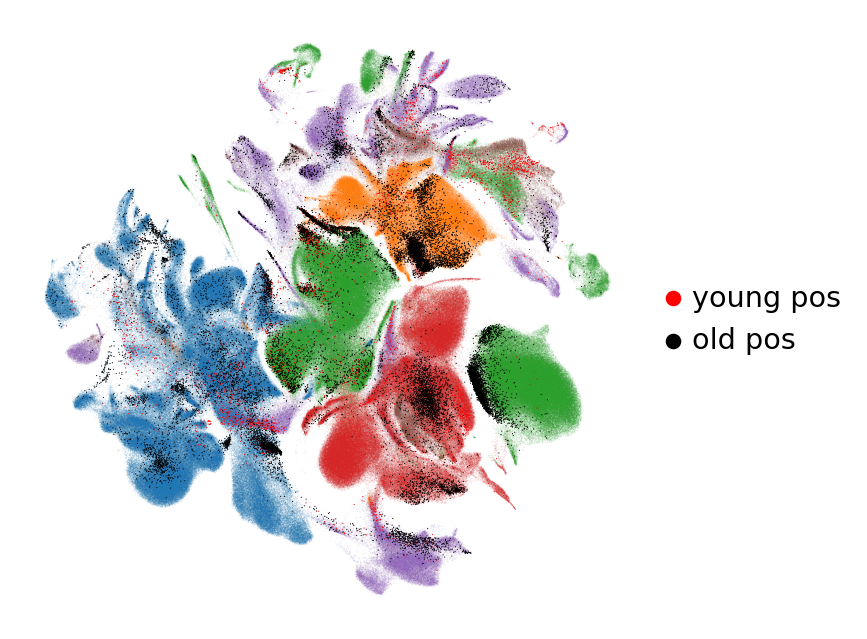

In [62]:
with rc_context({'figure.figsize': (5,5)}):
    ax = sc.pl.umap(adata, frameon = False, color = 'Class',
                    palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'],
                    s = .75, alpha = 0.15,
                    legend_loc = None, show = False)


    sc.pl.umap(adata[adata.obs.thing_young != 'neg'], color = 'thing_young', s = 1, palette = ['red'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs.thing_old != 'neg'], color = 'thing_old', s = 1, palette = ['k'],
               ax = ax, title = '', save = '_5B.svg')
    #

/tmp/ipykernel_1884252/1943949905.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['red', 'k'])


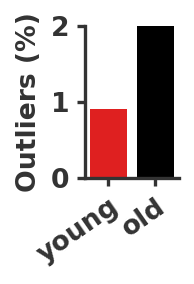

In [65]:
temp_val1 = len(adata.obs[adata.obs.thing_young == 'young pos'])\
    /len(adata.obs[adata.obs.age < 50])*100

temp_val2 = len(adata.obs[adata.obs.thing_old == 'old pos'])\
    /len(adata.obs[adata.obs.age >= 50])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['red', 'k'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('Outliers (%)', size = 12, weight = 'bold', color = '0.2')

plt.ylim(top = 2) #actual value is 2.03, rounding...

ax.grid(False)

plt.savefig('figures/5B_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/5B_pt2.svg', bbox_inches = 'tight')


plt.show()

In [112]:
adata.obs = adata.obs.drop(columns = ['sen_score', 'sen_outlier'])

In [ ]:
sc.concat((adata, hippo))

In [ ]:
coords = sc.read_h5ad('for_poster/human_all_highly_var_SCVI.h5ad').obsm['X_umap']

In [ ]:
coords = sc.read_h5ad('../data/tms/TMS_BDATA_UMAP_COORDS.h5ad').obsm['X_umap']
adata.obsm['X_umap'] = coords

In [114]:
ls ../data/tms

TMS_BDATA_UMAP_COORDS.h5ad  tabula-muris-senis-droplet-official-raw-obj.h5ad
blood_scvi.h5ad             tabula-muris-senis-facs-official-raw-obj.h5ad
blood_scvi_filtered.h5ad    tms-scVI-raw-data.h5ad
bloodless_scvi.h5ad         tms-scVI-raw-data_BDATA.h5ad


In [116]:
sc.read_h5ad('for_poster/human_all_highly_var_SCVI.h5ad').obs

,tissue,cell_type,age,sex,donor,sample,disease,tech,study,ref,cell_type_2,_scvi_batch,_scvi_labels
AAACCTGAGCAGCCTC-1_L1,liver,endothelial cell of hepatic sinusoid,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,endothelial cell,0,0
AAACCTGTCTAAGCCA-1_L1,liver,endothelial cell of hepatic sinusoid,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,endothelial cell,0,0
AAACGGGAGTAGGCCA-1_L1,liver,macrophage,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,macrophage,0,0
AAACGGGAGTTAGCGG-1_L1,liver,monocyte,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,monocyte,0,0
AAACGGGGTCGGGTCT-1_L1,liver,monocyte,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,monocyte,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCATATCAGCAACAAGCTA-38,hippocampus,dentate granule cell,88.0,M,38,38,healthy,SPLiT-seq,GSE198323,10.1038/s41586-022-04912-w,dentate granule cell,0,0
TTCACGCATATCAGCACATCAAGT-38,hippocampus,oligodendrocyte,88.0,M,38,38,healthy,SPLiT-seq,GSE198323,10.1038/s41586-022-04912-w,oligodendrocyte,0,0
TTCACGCATATCAGCACGCATACA-38,hippocampus,GABA interneuron,88.0,M,38,38,healthy,SPLiT-seq,GSE198323,10.1038/s41586-022-04912-w,GABA interneuron,0,0
TTCACGCATGAAGAGACATCAAGT-38,hippocampus,excitatory neuron,88.0,M,38,38,healthy,SPLiT-seq,GSE198323,10.1038/s41586-022-04912-w,excitatory neuron,0,0


In [ ]:
#sex UMAP

In [14]:
adata.obs['sex'] = adata.obs.sex.map(lambda x: x.strip())

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


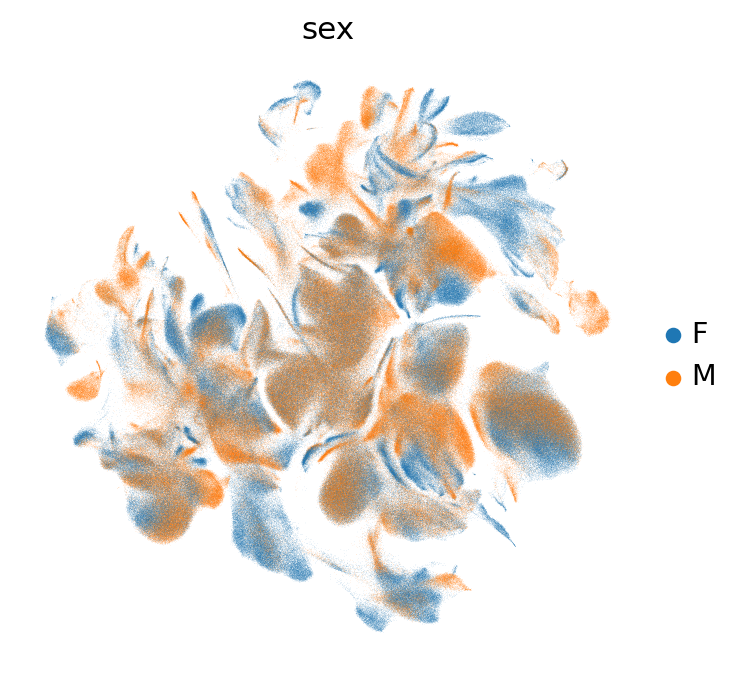

In [15]:
with rc_context({'figure.figsize': (5,5)}):
    sc.pl.umap(adata, color = 'sex', frameon=False,
                save = 'SB_pt3.svg') 

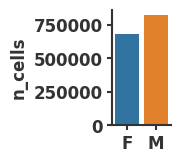

In [29]:

plt.figure(figsize = (0.75, 1.5))
ax = sns.barplot(data = adata.obs.groupby('sex').size().reset_index(name = 'n_cells'),
            x = 'sex', y = 'n_cells', hue = 'sex')


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('n_cells', size = 12, weight = 'bold', color = '0.2')
plt.xlabel('')

plt.savefig('figures/S1B_pt3.svg', bbox_inches = 'tight')


ax.grid(False)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


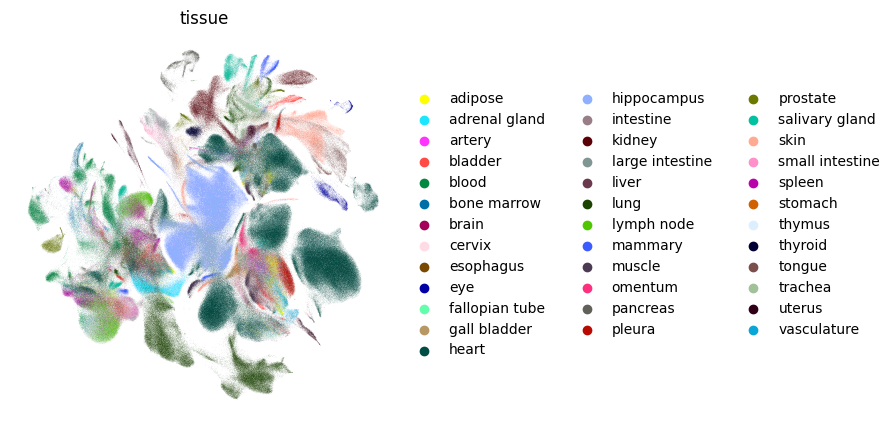

In [36]:
with rc_context({'figure.figsize': (5,5)}):
    sc.pl.umap(adata, color = 'tissue', frameon=False,
                ) #save = 'SB_pt1.svg'

In [37]:
adata

AnnData object with n_obs × n_vars = 1504261 × 2000
    obs: 'tissue', 'cell_type', 'age', 'sex', 'donor', 'sample', 'disease', 'tech', 'study', 'ref', 'cell_type_2', '_scvi_batch', '_scvi_labels', 'sen_outlier', 'Class', 'thing_young', 'thing_old'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap', 'tissue_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    obsp: 'connectivities', 'distances'

/tmp/ipykernel_1255701/2471208951.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = sns.barplot(data = adata.obs.groupby('tissue').size().reset_index(name = 'n_cells'),


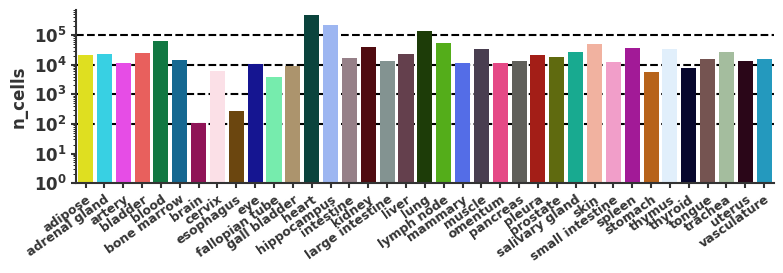

In [88]:
plt.figure(figsize = (9, 2.25))
ax = sns.barplot(data = adata.obs.groupby('tissue').size().reset_index(name = 'n_cells'),
            x = 'tissue', y = 'n_cells', hue = 'tissue', palette=adata.uns['tissue_colors'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 9, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('n_cells', size = 12, weight = 'bold', color = '0.2')
plt.xlabel('')
plt.yscale('log')

plt.axhline(100, ls = '--', c = 'k', zorder = 0)
plt.axhline(1000, ls = '--', c = 'k', zorder = 0)
plt.axhline(10000, ls = '--', c = 'k', zorder = 0)
plt.axhline(100000, ls = '--', c = 'k', zorder = 0)

plt.ylim(bottom=10**np.floor(np.log10(1)))

plt.savefig('figures/S1B_pt1.svg', bbox_inches = 'tight')


ax.grid(False)

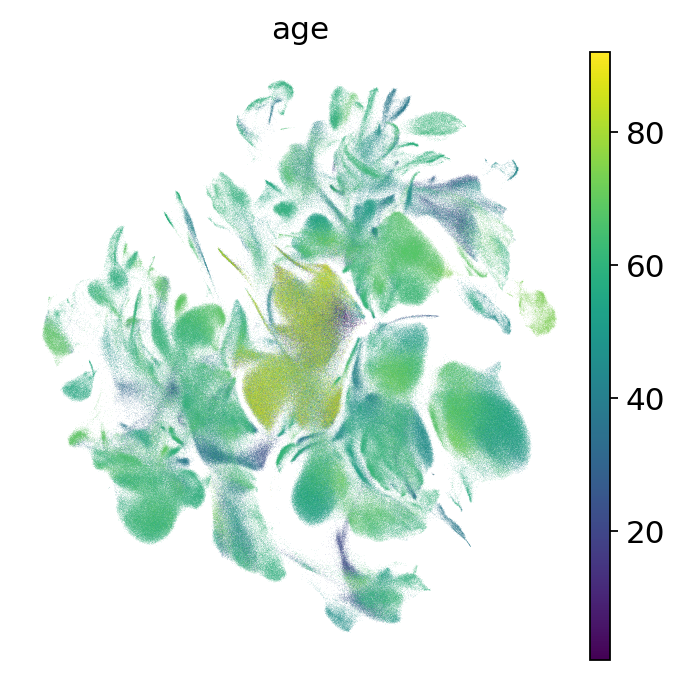

In [20]:
with rc_context({'figure.figsize': (5,5)}):
    sc.pl.umap(adata, color = 'age', frameon=False,
                save = 'SB_pt2.svg') 

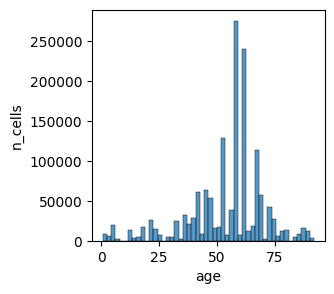

In [89]:

plt.figure(figsize = (3, 3))
ax = sns.histplot(data = adata.obs, x = 'age', bins=50)
#plt.yscale('log')
#plt.ylim(bottom = 0)
plt.ylabel('n_cells')

plt.savefig('figures/S1B_pt2.svg', bbox_inches = 'tight')
plt.show()

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


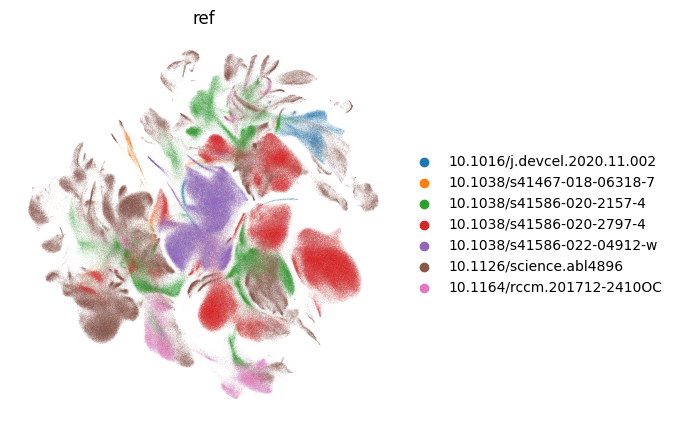

In [68]:
with rc_context({'figure.figsize': (5,5)}):
    sc.pl.umap(adata, color = 'ref', frameon=False, ) #save = 'SB_ref.svg'

/tmp/ipykernel_1255701/2019184629.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = sns.barplot(data = adata.obs.groupby('ref').size().reset_index(name = 'n_cells'),


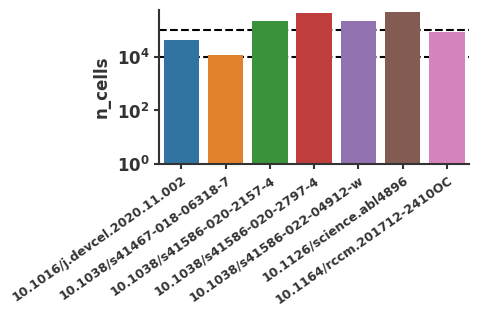

In [84]:
plt.figure(figsize = (4, 2))
ax = sns.barplot(data = adata.obs.groupby('ref').size().reset_index(name = 'n_cells'),
            x = 'ref', y = 'n_cells', hue = 'ref', palette=adata.uns['ref_colors'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 9, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('n_cells', size = 12, weight = 'bold', color = '0.2')
plt.xlabel('')
plt.yscale('log')

#plt.axhline(100, ls = '--', c = 'k', zorder = 0)
plt.axhline(10000, ls = '--', c = 'k', zorder = 0)
plt.axhline(100000, ls = '--', c = 'k', zorder = 0)


#plt.ylim(bottom = 0)
plt.ylim(bottom=10**np.floor(np.log10(1)))

plt.savefig('figures/S1B_ptref.svg', bbox_inches = 'tight')


ax.grid(False)